<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

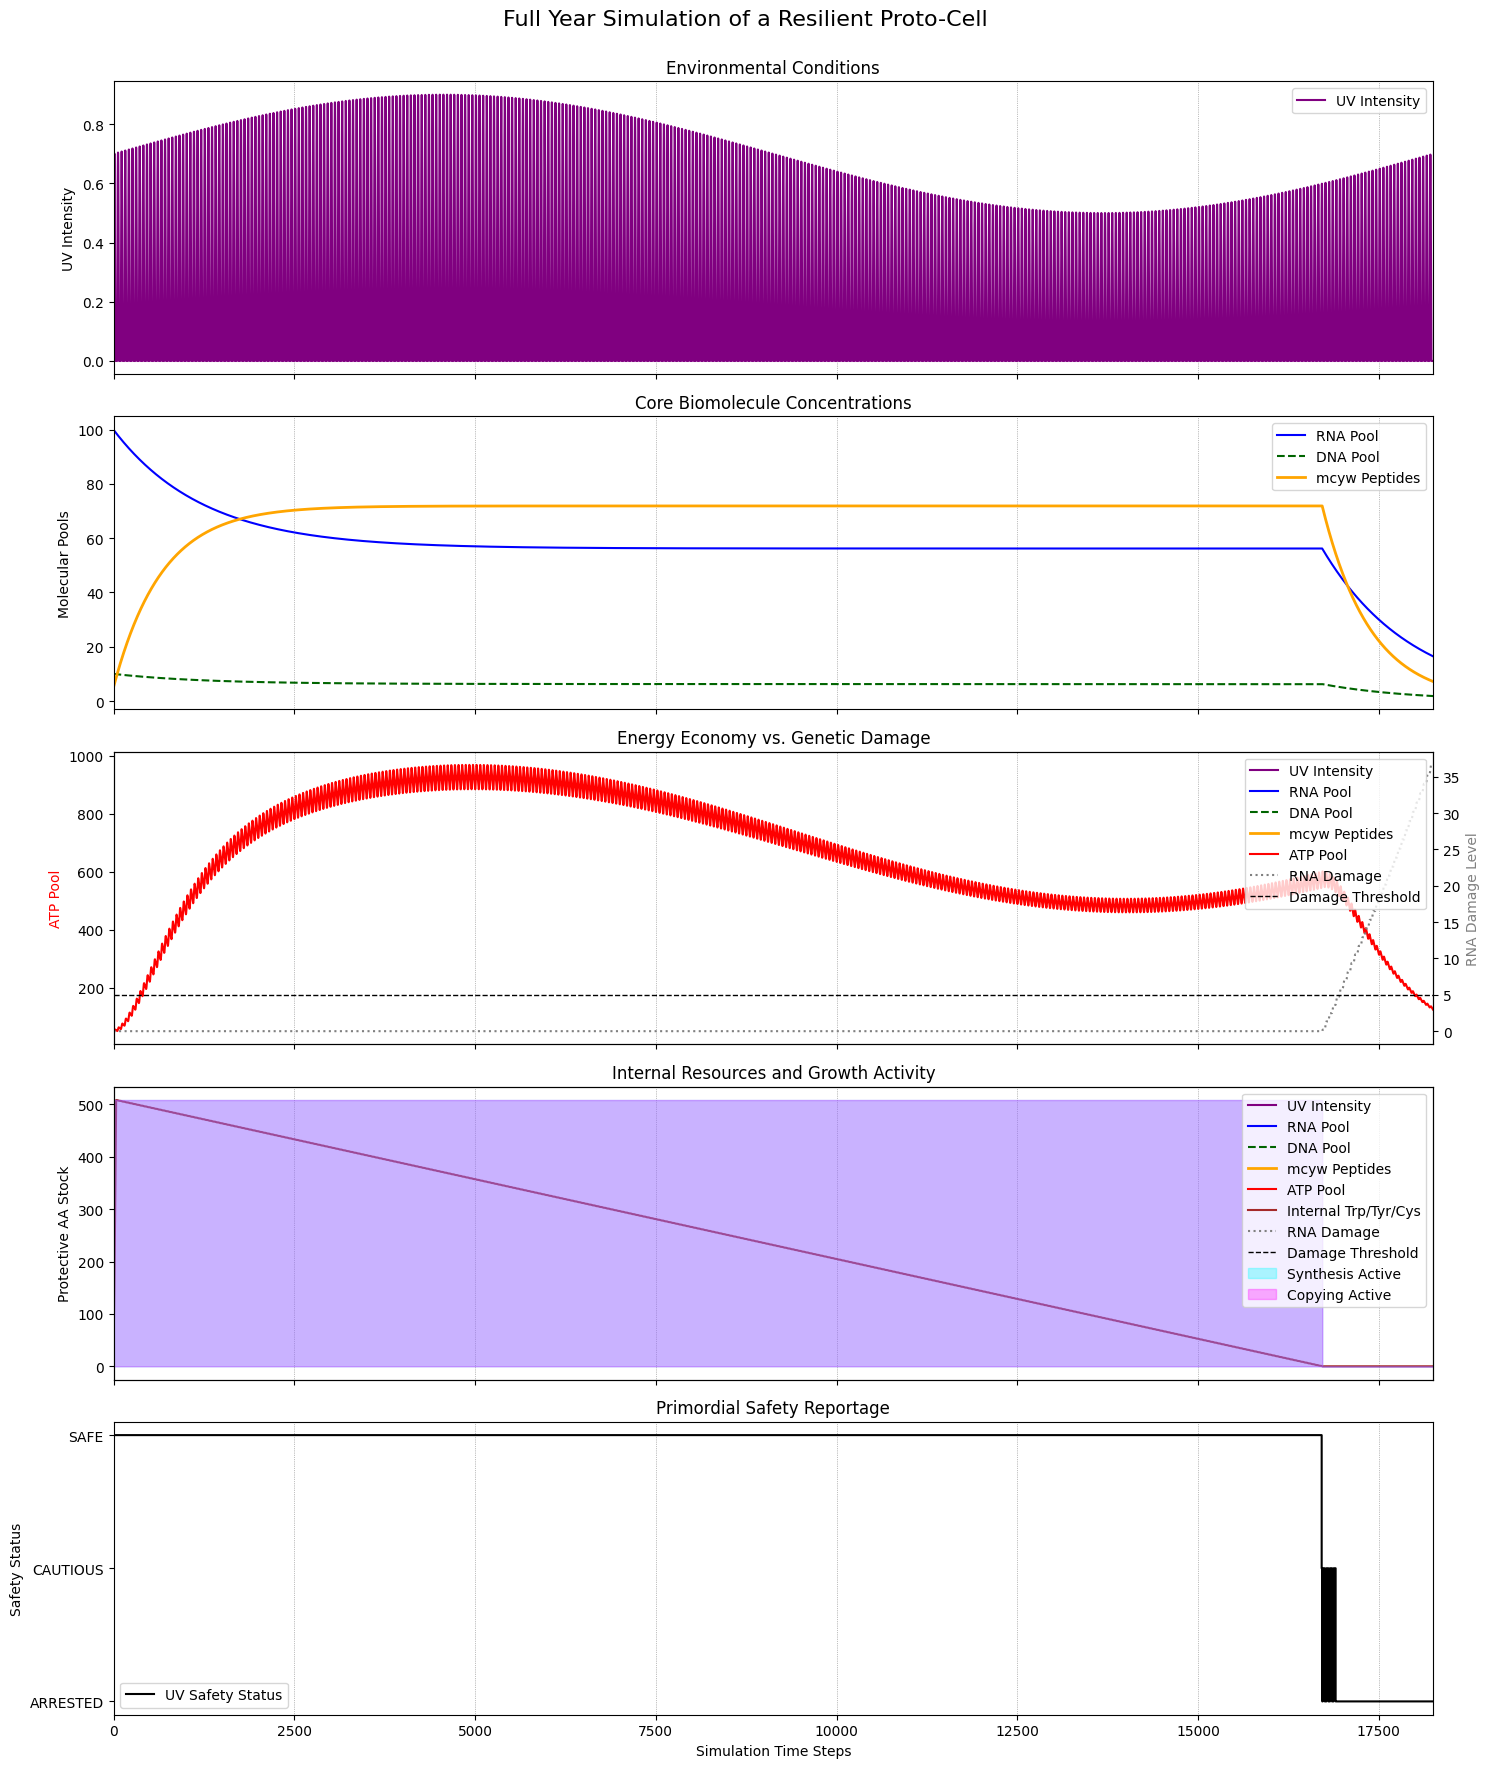

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Environmental & Global Parameters ---
class Environment:
    """
    Manages the external environment, including UV cycles with seasonal variation
    and external resource pools.
    """
    def __init__(self, total_sim_steps, days_per_cycle=50):
        self.total_sim_steps = total_sim_steps
        self.days_per_cycle = days_per_cycle
        self.time = 0  # Current time step

        # --- UV Profile with Seasonal Variation (Tuned for survivability) ---
        daily_uv_cycle = np.sin(np.linspace(0, 2 * np.pi, days_per_cycle))
        daily_uv_cycle[daily_uv_cycle < 0] = 0  # Night is 0 UV

        # Seasonal modulation to create a "less harsh" summer
        # Peak UV is now ~0.9 instead of 1.0
        # Range: 0.7 - 0.2 = 0.5 (winter) to 0.7 + 0.2 = 0.9 (summer)
        seasonal_amplitude_mod = 0.2 * np.sin(np.linspace(0, 2 * np.pi * (total_sim_steps / (365 * days_per_cycle)), total_sim_steps)) + 0.7

        # Combine daily cycle with seasonal modulation
        self.uv_intensity = np.zeros(total_sim_steps)
        for i in range(total_sim_steps):
            day_step_in_cycle = i % days_per_cycle
            self.uv_intensity[i] = daily_uv_cycle[day_step_in_cycle] * seasonal_amplitude_mod[i]

        # --- External Resource Pools (Essential for foraging) ---
        self.external_ntp_pool = 10000.0
        self.external_aa_pool = 10000.0
        self.external_trp_tyr_cys_pool = 500.0  # Scarce protective AAs

    def get_current_uv(self):
        """Returns the UV intensity at the current time step."""
        if self.time >= self.total_sim_steps:
            return 0.0
        return self.uv_intensity[self.time]

    def step(self):
        """Advances the environment one time step."""
        self.time += 1

# --- 2. Proto-Cell/System Class ---
class ProtoCell:
    """
    Represents the proto-cell, containing all molecular pools, states,
    and processes for survival and replication.
    """
    def __init__(self, env):
        self.env = env

        # Core Molecular Pools
        self.rna_pool = 100.0
        self.dna_pool = 10.0
        self.atp_pool = 50.0
        self.mcyw_peptide_pool = 5.0
        self.other_peptide_pool = 2.0

        # Internal Resource Stocks
        self.internal_ntp_stock = 100.0
        self.internal_aa_stock = 100.0
        self.internal_trp_tyr_cys_stock = 10.0

        # System States & Damage
        self.rna_damage_level = 0.0
        self.protein_synthesis_active = True
        self.rna_dna_copying_active = True
        self.uv_safety_status = "SAFE"
        self.premature_stop_signal = 0.0

        # --- PARAMETERS TUNED FOR RESILIENCE AND SUSTAINABILITY ---
        self.damage_tolerance_threshold = 5.0      # INCREASED: More tolerant to damage
        self.uv_damage_rate_per_uv = 0.12          # DECREASED: UV is less damaging per unit
        self.atp_generation_rate_per_mcyw_uv = 0.15# INCREASED: More energy from light
        self.repair_rate = 0.6                     # INCREASED: Much faster repair
        self.repair_atp_cost = 0.007               # DECREASED: Repair is cheaper

        # Foraging parameters
        self.foraging_efficiency_mcyw = 0.20
        self.foraging_atp_cost = 0.003
        self.trp_tyr_cys_foraging_bias = 10.0

        # Protein Synthesis parameters
        self.protein_synthesis_rate = 0.18
        self.protein_synthesis_ntp_cost = 0.1
        self.protein_synthesis_aa_cost = 0.1
        self.protein_synthesis_atp_cost = 0.02
        self.mcyw_synthesis_bias = 0.6

        # Safety Reportage Signal parameters
        self.precarious_codon_rate_per_damage = 0.3
        self.premature_stop_signal_threshold = 0.35
        self.trp_tyr_cys_for_repair_needed = 0.05

        # RNA/DNA Copying parameters
        self.rna_dna_copy_rate = 0.05
        self.rna_dna_copy_ntp_cost = 0.05
        self.rna_dna_copy_atp_cost = 0.01

        # Degradation rates
        self.rna_degradation_rate = 0.0008
        self.peptide_degradation_rate = 0.0015
        self.atp_degradation_rate = 0.003

    # --- Core Processes ---
    def _apply_uv_damage(self):
        current_uv = self.env.get_current_uv()
        if current_uv > 0:
            damage_increase = current_uv * self.uv_damage_rate_per_uv
            self.rna_damage_level += damage_increase
            self.premature_stop_signal = damage_increase * self.precarious_codon_rate_per_damage
        else:
            self.premature_stop_signal = 0

    def _forage(self):
        if self.mcyw_peptide_pool <= 0 or self.atp_pool <= self.foraging_atp_cost:
            return
        atp_consumed = self.foraging_atp_cost * self.mcyw_peptide_pool
        self.atp_pool = max(0, self.atp_pool - atp_consumed)

        general_foraged = self.foraging_efficiency_mcyw * self.mcyw_peptide_pool
        transfer_ntp = min(general_foraged / 2, self.env.external_ntp_pool)
        transfer_aa = min(general_foraged / 2, self.env.external_aa_pool)
        self.internal_ntp_stock += transfer_ntp
        self.env.external_ntp_pool -= transfer_ntp
        self.internal_aa_stock += transfer_aa
        self.env.external_aa_pool -= transfer_aa

        rare_foraged = general_foraged * self.trp_tyr_cys_foraging_bias
        transfer_rare = min(rare_foraged, self.env.external_trp_tyr_cys_pool)
        self.internal_trp_tyr_cys_stock += transfer_rare
        self.env.external_trp_tyr_cys_pool -= transfer_rare

    def _synthesize_protein(self):
        if not self.protein_synthesis_active:
            return

        total_protein_units_to_make = self.protein_synthesis_rate
        total_ntp_cost = total_protein_units_to_make * self.protein_synthesis_ntp_cost
        total_aa_cost = total_protein_units_to_make * self.protein_synthesis_aa_cost
        total_atp_cost = total_protein_units_to_make * self.protein_synthesis_atp_cost

        if self.internal_ntp_stock < total_ntp_cost or self.internal_aa_stock < total_aa_cost or self.atp_pool < total_atp_cost:
            return

        mcyw_units_made = 0
        if self.internal_trp_tyr_cys_stock > 0 and self.mcyw_synthesis_bias > 0:
            rare_aa_cost = self.protein_synthesis_aa_cost * self.mcyw_synthesis_bias
            general_aa_cost = self.protein_synthesis_aa_cost * (1 - self.mcyw_synthesis_bias)
            max_mcyw_from_rare = self.internal_trp_tyr_cys_stock / rare_aa_cost if rare_aa_cost > 0 else float('inf')
            max_mcyw_from_general = self.internal_aa_stock / general_aa_cost if general_aa_cost > 0 else float('inf')
            mcyw_units_made = min(total_protein_units_to_make * self.mcyw_synthesis_bias, max_mcyw_from_rare, max_mcyw_from_general)

        other_peptide_units_made = total_protein_units_to_make - mcyw_units_made

        if mcyw_units_made > 0:
            self.internal_trp_tyr_cys_stock -= mcyw_units_made * (self.protein_synthesis_aa_cost * self.mcyw_synthesis_bias)
            self.internal_aa_stock -= mcyw_units_made * (self.protein_synthesis_aa_cost * (1 - self.mcyw_synthesis_bias))
            self.mcyw_peptide_pool += mcyw_units_made

        if other_peptide_units_made > 0:
            self.internal_ntp_stock -= other_peptide_units_made * self.protein_synthesis_ntp_cost
            self.internal_aa_stock -= other_peptide_units_made * self.protein_synthesis_aa_cost
            self.other_peptide_pool += other_peptide_units_made

        self.atp_pool -= total_atp_cost
        self.internal_ntp_stock = max(0, self.internal_ntp_stock)
        self.internal_aa_stock = max(0, self.internal_aa_stock)
        self.internal_trp_tyr_cys_stock = max(0, self.internal_trp_tyr_cys_stock)
        self.atp_pool = max(0, self.atp_pool)

    def _synthesize_atp(self):
        current_uv = self.env.get_current_uv()
        if current_uv > 0 and self.mcyw_peptide_pool > 0:
            atp_generated = self.atp_generation_rate_per_mcyw_uv * self.mcyw_peptide_pool * current_uv
            self.atp_pool += atp_generated

    def _repair_rna_dna(self):
        if self.rna_damage_level > 0:
            if self.atp_pool >= self.repair_atp_cost and self.internal_trp_tyr_cys_stock >= self.trp_tyr_cys_for_repair_needed:
                self.atp_pool -= self.repair_atp_cost
                self.internal_trp_tyr_cys_stock -= self.trp_tyr_cys_for_repair_needed
                repaired_amount = min(self.rna_damage_level, self.repair_rate)
                self.rna_damage_level -= repaired_amount
                self.atp_pool = max(0, self.atp_pool)
                self.internal_trp_tyr_cys_stock = max(0, self.internal_trp_tyr_cys_stock)

    def _copy_rna_dna(self):
        if not self.rna_dna_copying_active:
            return
        if self.internal_ntp_stock >= self.rna_dna_copy_ntp_cost and self.atp_pool >= self.rna_dna_copy_atp_cost:
            self.internal_ntp_stock -= self.rna_dna_copy_ntp_cost
            self.atp_pool -= self.rna_dna_copy_atp_cost
            self.rna_pool += self.rna_dna_copy_rate * 0.9
            self.dna_pool += self.rna_dna_copy_rate * 0.1
            self.internal_ntp_stock = max(0, self.internal_ntp_stock)
            self.atp_pool = max(0, self.atp_pool)

    def _degrade(self):
        self.rna_pool = max(0, self.rna_pool * (1 - self.rna_degradation_rate))
        self.dna_pool = max(0, self.dna_pool * (1 - self.rna_degradation_rate))
        self.mcyw_peptide_pool = max(0, self.mcyw_peptide_pool * (1 - self.peptide_degradation_rate))
        self.other_peptide_pool = max(0, self.other_peptide_pool * (1 - self.peptide_degradation_rate))
        self.atp_pool = max(0, self.atp_pool * (1 - self.atp_degradation_rate))

    def _manage_state(self):
        normalized_damage = min(1.0, self.rna_damage_level / self.damage_tolerance_threshold)

        scarcity_signal = 0.0
        if self.internal_trp_tyr_cys_stock < self.trp_tyr_cys_for_repair_needed * 5 and self.env.get_current_uv() > 0.1:
            scarcity_signal = 1.0 - (self.internal_trp_tyr_cys_stock / (self.trp_tyr_cys_for_repair_needed * 5))
            scarcity_signal = max(0, min(1, scarcity_signal))

        stop_signal = self.premature_stop_signal * self.env.get_current_uv()
        danger_metric = (normalized_damage * 0.4) + (scarcity_signal * 0.4) + (stop_signal * 0.2)

        if danger_metric >= self.premature_stop_signal_threshold:
            self.protein_synthesis_active = False
            self.rna_dna_copying_active = False
            self.uv_safety_status = "ARRESTED"
        elif danger_metric < self.premature_stop_signal_threshold * 0.1 and self.internal_trp_tyr_cys_stock > self.trp_tyr_cys_for_repair_needed * 10:
            self.protein_synthesis_active = True
            self.rna_dna_copying_active = True
            self.uv_safety_status = "SAFE"
        else:
             self.uv_safety_status = "CAUTIOUS"

    def step(self):
        """Executes all proto-cell processes for a single time step."""
        self._apply_uv_damage()
        self._synthesize_atp()
        self._forage()
        self._repair_rna_dna()
        self._manage_state() # This must happen before synthesis/copying
        self._synthesize_protein()
        self._copy_rna_dna()
        self._degrade()

# --- 3. Simulation Runner ---
def run_simulation(total_steps, days_per_cycle):
    env = Environment(total_steps, days_per_cycle)
    cell = ProtoCell(env)

    data_keys = ['time', 'uv_intensity', 'rna_pool', 'dna_pool', 'atp_pool',
                 'mcyw_peptide_pool', 'rna_damage_level', 'uv_safety_status',
                 'internal_trp_tyr_cys_stock', 'protein_synthesis_active',
                 'rna_dna_copying_active']
    data = {key: [] for key in data_keys}

    for _ in range(total_steps):
        current_uv = env.get_current_uv()
        cell.step()

        data['time'].append(env.time)
        data['uv_intensity'].append(current_uv)
        data['rna_pool'].append(cell.rna_pool)
        data['dna_pool'].append(cell.dna_pool)
        data['atp_pool'].append(cell.atp_pool)
        data['mcyw_peptide_pool'].append(cell.mcyw_peptide_pool)
        data['rna_damage_level'].append(cell.rna_damage_level)
        data['uv_safety_status'].append(cell.uv_safety_status)
        data['internal_trp_tyr_cys_stock'].append(cell.internal_trp_tyr_cys_stock)
        data['protein_synthesis_active'].append(1 if cell.protein_synthesis_active else 0)
        data['rna_dna_copying_active'].append(1 if cell.rna_dna_copying_active else 0)

        env.step()

    return pd.DataFrame(data)

# --- 4. Main Execution and Visualization ---
if __name__ == "__main__":
    # Simulation Settings
    SIMULATION_DAYS = 365
    STEPS_PER_DAY = 50
    TOTAL_STEPS = SIMULATION_DAYS * STEPS_PER_DAY

    # Run the simulation
    results_df = run_simulation(total_steps=TOTAL_STEPS, days_per_cycle=STEPS_PER_DAY)

    # --- Plotting ---
    fig, axs = plt.subplots(5, 1, figsize=(15, 18), sharex=True)
    fig.suptitle('Full Year Simulation of a Resilient Proto-Cell', fontsize=16)

    # Get a dummy cell for plotting thresholds
    dummy_cell = ProtoCell(Environment(1, STEPS_PER_DAY))

    # Plot 1: UV Intensity
    axs[0].plot(results_df['time'], results_df['uv_intensity'], color='purple', label='UV Intensity')
    axs[0].set_ylabel('UV Intensity')
    axs[0].set_title('Environmental Conditions')
    axs[0].fill_between(results_df['time'], 0, results_df['uv_intensity'], color='purple', alpha=0.1)
    axs[0].legend()

    # Plot 2: Molecular Pools
    axs[1].plot(results_df['time'], results_df['rna_pool'], label='RNA Pool', color='blue')
    axs[1].plot(results_df['time'], results_df['dna_pool'], label='DNA Pool', color='darkgreen', linestyle='--')
    axs[1].plot(results_df['time'], results_df['mcyw_peptide_pool'], label='mcyw Peptides', color='orange', linewidth=2)
    axs[1].set_ylabel('Molecular Pools')
    axs[1].set_title('Core Biomolecule Concentrations')
    axs[1].legend()

    # Plot 3: Energy and Damage
    ax3_twin = axs[2].twinx() # Create a twin axis for damage
    axs[2].plot(results_df['time'], results_df['atp_pool'], label='ATP Pool', color='red')
    ax3_twin.plot(results_df['time'], results_df['rna_damage_level'], label='RNA Damage', color='grey', linestyle=':')
    ax3_twin.axhline(y=dummy_cell.damage_tolerance_threshold, color='black', linestyle='--', linewidth=1, label='Damage Threshold')
    axs[2].set_ylabel('ATP Pool', color='red')
    ax3_twin.set_ylabel('RNA Damage Level', color='grey')
    axs[2].set_title('Energy Economy vs. Genetic Damage')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=axs[2].transAxes)

    # Plot 4: Internal Resources and Activity State
    axs[3].plot(results_df['time'], results_df['internal_trp_tyr_cys_stock'], label='Internal Trp/Tyr/Cys', color='brown')
    axs[3].set_ylabel('Protective AA Stock')
    axs[3].set_title('Internal Resources and Growth Activity')
    ax4_twin = axs[3].twinx()
    ax4_twin.fill_between(results_df['time'], 0, results_df['protein_synthesis_active'], color='cyan', alpha=0.3, label='Synthesis Active')
    ax4_twin.fill_between(results_df['time'], 0, results_df['rna_dna_copying_active'], color='magenta', alpha=0.3, label='Copying Active')
    ax4_twin.set_yticks([])
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=axs[3].transAxes)

    # Plot 5: UV Safety Status
    status_map = {"SAFE": 1, "CAUTIOUS": 0.5, "ARRESTED": 0}
    status_numeric = [status_map[s] for s in results_df['uv_safety_status']]
    axs[4].plot(results_df['time'], status_numeric, label='UV Safety Status', color='black', drawstyle='steps-post')
    axs[4].set_ylabel('Safety Status')
    axs[4].set_yticks([0, 0.5, 1])
    axs[4].set_yticklabels(["ARRESTED", "CAUTIOUS", "SAFE"])
    axs[4].set_title('Primordial Safety Reportage')
    axs[4].set_xlabel('Simulation Time Steps')
    axs[4].legend()

    # General formatting
    for ax in axs:
        ax.grid(True, which='major', axis='x', linestyle=':', linewidth='0.5', color='gray')
        ax.set_xlim(0, TOTAL_STEPS)

    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust for suptitle
    plt.show()

